# NDVI Phenology

### Background

Phenology is the study of how plant and animal life varies both with the season, and the climate more broadly. 

This notebook calculates vegetation phenology changes using Landsat-7 and/or Landsat-8 data. To detect changes in plant life, the algorithm uses the normalised difference vegetation index NDVI as a common proxy for vegetation growth and health. The output from this notebook can be used to assess differences in agriculture fields over time or space and also allow the assessment of growing states such as planting and harvesting.  

The output product is a statistical time series plot of NDVI with the data "binned" into weeks or months. The timeline can be changed from a single year (all data binned with the 12-month period) or spread out over the entire time window of the analysis. 

See this website for more information: https://phenology.cr.usgs.gov/ndvi_foundation.php

## Preliminary steps

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'my_app')

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

# Import other required packages
import matplotlib.pyplot as plt
import numpy as np  
import xarray as xr  
import pandas as pd
import datetime as dt

## Define product and extent

### Available extents

We've listed the available ingested data that you can explore in the ODC Sandbox. The latitude, longitude and time ranges correspond to the boundaries of the ingested data cubes. You'll be able to explore sub-samples of these cubes. You'll also need to provide the platform, product and resolution information for the cube you're subsampling.

#### LS8 Caqueta
Platform: `'LANDSAT_8'` <br>
Product: `'ls8_collection1_AMA_ingest'` <br>
Latitude:   `(0.000134747292617865, 1.077843593651382)` <br>
Longitude:  `(-74.91935994831539, -73.30266193148462)` <br>
Time:       `('2013-04-13', '2018-03-26')` <br>
Resolution: `(-0.000269494585236, 0.000269494585236)`

#### LS8 Vietnam
Platform: `'LANDSAT_8'` <br>
Product: `'ls8_collection1_AMA_ingest'` <br>
Latitude:  `(10.513927001104687, 12.611133863411238)` <br>
Longitude: `(106.79005909290998, 108.91906631627438)` <br>
Time: `('2014-01-14', '2016-12-21')` <br>
Resolution: `(-0.000269494585236, 0.000269494585236)` <br>

#### LS7 Caqueta
Platform: `'LANDSAT_7'` <br>
Product: `'ls7_collection1_AMA_ingest'` <br>
Latitude:  `(0.000134747292617865, 1.077843593651382)` <br>
Longitude: `(-74.91935994831539, -73.30266193148462)` <br>
Time: `('1999-08-21', '2018-03-25')` <br>
Resolution: `(-0.000269494585236, 0.000269494585236)`

#### LS7 Lake Baringo
Platform: `'LANDSAT_7'` <br>
Product: `'ls7_collection1_AMA_ingest'` <br>
Latitude:  `(0.4997747685, 0.7495947795)` <br>
Longitude: `(35.9742163305, 36.473586859499996)` <br>
Time: `('2005-01-08', '2016-12-24')` <br>
Resolution: `(-0.000269493, 0.000269493)`

In [3]:
# CHANGE HERE >>>>>>>>>>>>>>>>>

# Select a product and platform
platform = "LANDSAT_7"
product = 'ls7_collection1_AMA_ingest'
resolution = (-0.000269494585236, 0.000269494585236)
output_crs = 'EPSG:4326'

### Set extent information

You can change the values in this cell to specify the extent of the data cube you wish to analyse.

You should select a sub-sample from one of the four data cubes listed above. When subsampling, keep in mind that:
* Your latitude and longitude bounds should be within the extents given.
* Your area should be small to keep load times reasonable (less than 0.5 square degrees).
* Your time period should be within the extents given.

You should format the variables as:
* `latitude = (min_latitude, max_latitude)`
* `longitude = (min_longitude, max_longitude)`
* `time_extents = (min_time, max_time)`, where each time has the format: `'YYYY-MM-DD'`.

In [4]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>

# Select a sub-region to analyse
latitude = (0.49964002, 0.74964002)
longitude  = (36.0, 36.3)
time_extents = ('2007-01-01', '2009-01-01')

### View the region before loading

The next cell will allow you to view the area you'll be analysing by displaying a red bounding box on an interactive map. You can change the extents in the previous cell and rerun the `display_map()` command to see the resulting bounding box.

In [5]:
# The code below renders a map that can be used to view the analysis region.
from utils.data_cube_utilities.dc_display_map import display_map

display_map(latitude, longitude)

## Load the dataset and the required spectral bands or other parameters
The data is loaded by passing the product and area information to the `dc.load()` function. As a part of this load, we also specify the measurements we want in the form of the Landsat bands.

The load can take up to a few minutes, so please be patient.

In [6]:
measurements = ['red', 'blue', 'green', 'nir', 'swir1', 'swir2', 'pixel_qa']

landsat_dataset = dc.load(
    latitude=latitude,
    longitude=longitude,
    platform=platform,
    time=time_extents,
    product=product,
    output_crs=output_crs,
    resolution=resolution,
    measurements=measurements
)

It is often useful to print the loaded data to check the dimensions and data variables

When looking at the dimensions, the numbers for latitude and longitude correspond to the number of pixels in each dimension and the number for time corresponds to the number of time steps. 

In [7]:
# Displays an overview of the loaded data
print(landsat_dataset)

<xarray.Dataset>
Dimensions:    (latitude: 928, longitude: 1114, time: 27)
Coordinates:
  * time       (time) datetime64[ns] 2007-02-15T07:39:23 2007-03-03T07:39:27 ...
  * latitude   (latitude) float64 0.7496 0.7493 0.7491 0.7488 0.7485 0.7483 ...
  * longitude  (longitude) float64 36.0 36.0 36.0 36.0 36.0 36.0 36.0 36.0 ...
Data variables:
    red        (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    blue       (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    green      (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    nir        (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    swir1      (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    swir2      (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    pixel_qa   (time, latitude, longitude) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Attributes:
    crs:      EPSG:4326


## Masking out clouds

As part of the utilities for the Open Data Cube, we have defined a function to mask clouds based on the quality assurance information for Landsat. The function returns an `xarray.DataArray` object containing the mask. This can then be passed to the `where()` function, which masks the data.

In [8]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask

cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)

cleaned_dataset = landsat_dataset.where(cloud_mask)

## Create the NDVI Phenology Product

The first step is to caculate the normalised difference vegetation index (NDVI). Here, we use the `NDVI()` function, defined in the utilities. This is applied to the clean dataset, and then the result is addedd as a data variable.

In [9]:
from utils.data_cube_utilities.dc_ndvi_anomaly import NDVI

ndvi_arr = NDVI(cleaned_dataset)

cleaned_dataset['ndvi'] = ndvi_arr

The next step is to generate a box-and-whisker plot for the NDVI. The box-and-whisker plot is calculated by getting the relevant statistics for binned data.  

Set the binning variable `bin_size` to one of the following: <br>
`'fortnight'`, which bins the data by each fortnight in the timeframe<br>
`'month'`, which bins the data by each month in the timeframe<br>
`'weekofyear'`, which aggregates the data over all years and bins it by week<br>
`'monthofyear'`, which aggregates the data over all years and bins it by month

*Note:* the `'fortnight'` and `'month'` settings may cause the notebook to crash if the timespan of the data is greater than two years.

It's also possible to plot a polynomial curve fit to the mean of the NDVI over time. Set the `plot_curve_fit_ndvi_mean` variable to one of the following: <br>
`True`, which includes the fit in the plot <br>
`False`, which excludes the fit from the plot

Depending on the timeframe, you may need to change the degree of the polynomial you're fitting. Set the polynomial degree by changing the value for `polynomial_degree`:<br>
`polynomial_degree = 3` will fit the peaks and troughs over a single year<br>
`polynomial_degree = 5` will fit the peaks and troughs over two years

In [15]:
# CHANGE HERE >>>>>>>>>>>>>>>>> 

# Import function and determine settings for box-and-whisker plot
from utils.data_cube_utilities.plotter_utils import xarray_time_series_plot

bin_size = 'month'
plot_curve_fit_ndvi_mean = True
polynomial_degree = 5

The next step is to resample the data based on the binning setting chosen above. The following code also sets up the plotting parameters.

In [16]:
# Resample the data based on bin_size prior to plotting
for bin_by in [bin_size]:
    aggregated_by_str = None
    if bin_by is None:
        plotting_data = cleaned_dataset
    elif bin_by == 'fortnight':
        plotting_data = cleaned_dataset.resample(time='2w').mean()
        aggregated_by_str = 'Fortnight'
    elif bin_by == 'month':
        plotting_data = cleaned_dataset.resample(time='1m').mean()
        aggregated_by_str = 'Month'
    elif bin_by == 'weekofyear':
        plotting_data = cleaned_dataset.groupby('time.week').mean(dim=('time'))
        aggregated_by_str = 'Week of Year'
    elif bin_by == 'monthofyear':
        plotting_data = cleaned_dataset.groupby('time.month').mean(dim=('time'))
        aggregated_by_str = 'Month of Year'

# Set any parameters for the plot
params = dict(dataset=plotting_data, plot_descs={'ndvi':{'none':[
    {'box':{'boxprops':{'facecolor':'forestgreen'}}}]}})
params['scale_params'] = 'norm'

# Set parameters for plotting the polynomial fit
if plot_curve_fit_ndvi_mean:
    params['plot_descs']['ndvi']['mean'] = [{'poly': {'degree': polynomial_degree}}]

The final step is to make the plot.

NDVI (Aggregated by Month)


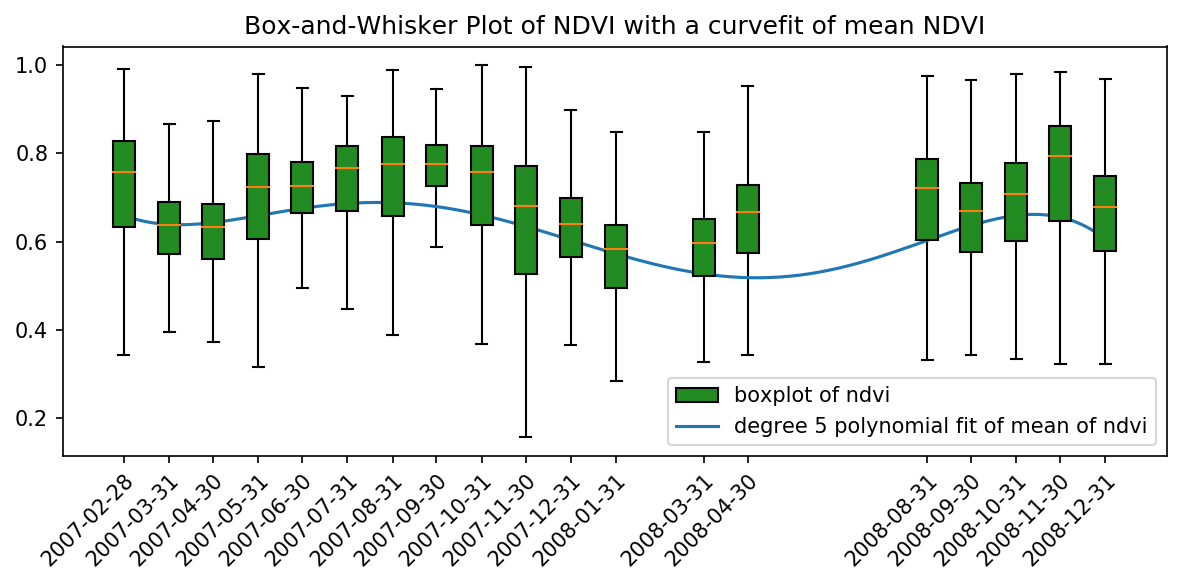

In [17]:
# Make the plot  
xarray_time_series_plot(**params, fig_params=dict(figsize=(8,4), dpi=150))
plt.title('Box-and-Whisker Plot of NDVI with a curvefit of mean NDVI')

print("NDVI {}".format("(Aggregated by {})".format(aggregated_by_str) if aggregated_by_str is not None else ""))